In [1]:
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import cellpose
from cellpose import utils, io, models, plot
from cellpose.utils import outlines_list, masks_to_outlines
import os, sys
import glob
import cv2
from shapely.geometry import Polygon
import torch
import importlib
importlib.reload(models)
import csv
from pathlib import Path

currentdir = os.path.dirname(os.path.realpath('cell_polygons.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

Downloading: "https://www.cellpose.org/models/cyto_0" to /root/.cellpose/models/cyto_0
100%|██████████| 25.2M/25.2M [00:03<00:00, 8.20MB/s]
Downloading: "https://www.cellpose.org/models/cyto_1" to /root/.cellpose/models/cyto_1
100%|██████████| 25.2M/25.2M [00:03<00:00, 6.79MB/s]
Downloading: "https://www.cellpose.org/models/cyto_2" to /root/.cellpose/models/cyto_2
100%|██████████| 25.2M/25.2M [00:02<00:00, 8.89MB/s]
Downloading: "https://www.cellpose.org/models/cyto_3" to /root/.cellpose/models/cyto_3
100%|██████████| 25.2M/25.2M [00:03<00:00, 6.76MB/s]
Downloading: "https://www.cellpose.org/models/size_cyto_0.npy" to /root/.cellpose/models/size_cyto_0.npy
100%|██████████| 3.55k/3.55k [00:00<00:00, 3.86MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_0" to /root/.cellpose/models/cytotorch_0
100%|██████████| 25.3M/25.3M [00:02<00:00, 8.91MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_1" to /root/.cellpose/models/cytotorch_1
100%|██████████| 25.3M/25.3M [00:04

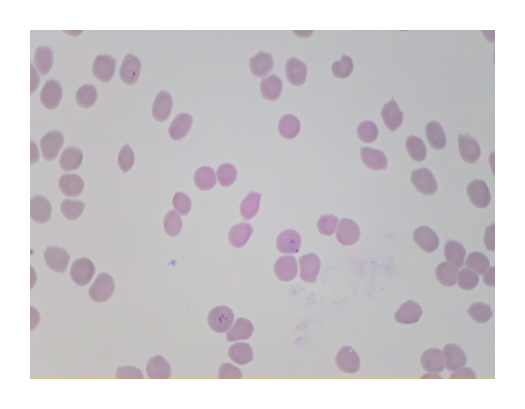

In [10]:
# cralws folder for files ending with .jpeg

def get_jpeg(path):
    list_jpeg = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpeg"):
                jpeg_path = os.path.join(root, file)
                list_jpeg.append(jpeg_path)
    return list_jpeg

org_files = get_jpeg('../data/scan_clean/vgg_test')
org_files

# view 1 image
img = io.imread(org_files[0])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
imgs = [cv2.imread(img_path) for img_path in org_files]

In [5]:
masks_all = []
img_len = len(imgs)
model = models.Cellpose(gpu=True, model_type='cyto')
chan = [0, 0] # for black and white imgs
diameter = 170

for i in range(img_len):
    masks, flows, styles, diams = model.eval(imgs[i], 
                                diameter= diameter, 
                                channels=chan,
                                invert = True,
                                flow_threshold = 1)
    masks_all.append(masks)

TORCH CUDA version not installed/working.
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 105.14s; flow+mask computation 2.99
estimated masks for 1 image(s) in 109.37 sec
>>>> TOTAL TIME 109.37 sec
processing 1 image(s)
time spent: running network 73.44s; flow+mask computation 2.99
estimated masks for 1 image(s) in 77.72 sec
>>>> TOTAL TIME 77.74 sec
processing 1 image(s)
time spent: running network 66.26s; flow+mask computation 2.75
estimated masks for 1 image(s) in 69.97 sec
>>>> TOTAL TIME 69.97 sec
processing 1 image(s)
time spent: running network 78.35s; flow+mask computation 2.86
estimated masks for 1 image(s) in 82.12 sec
>>>> TOTAL TIME 82.12 sec


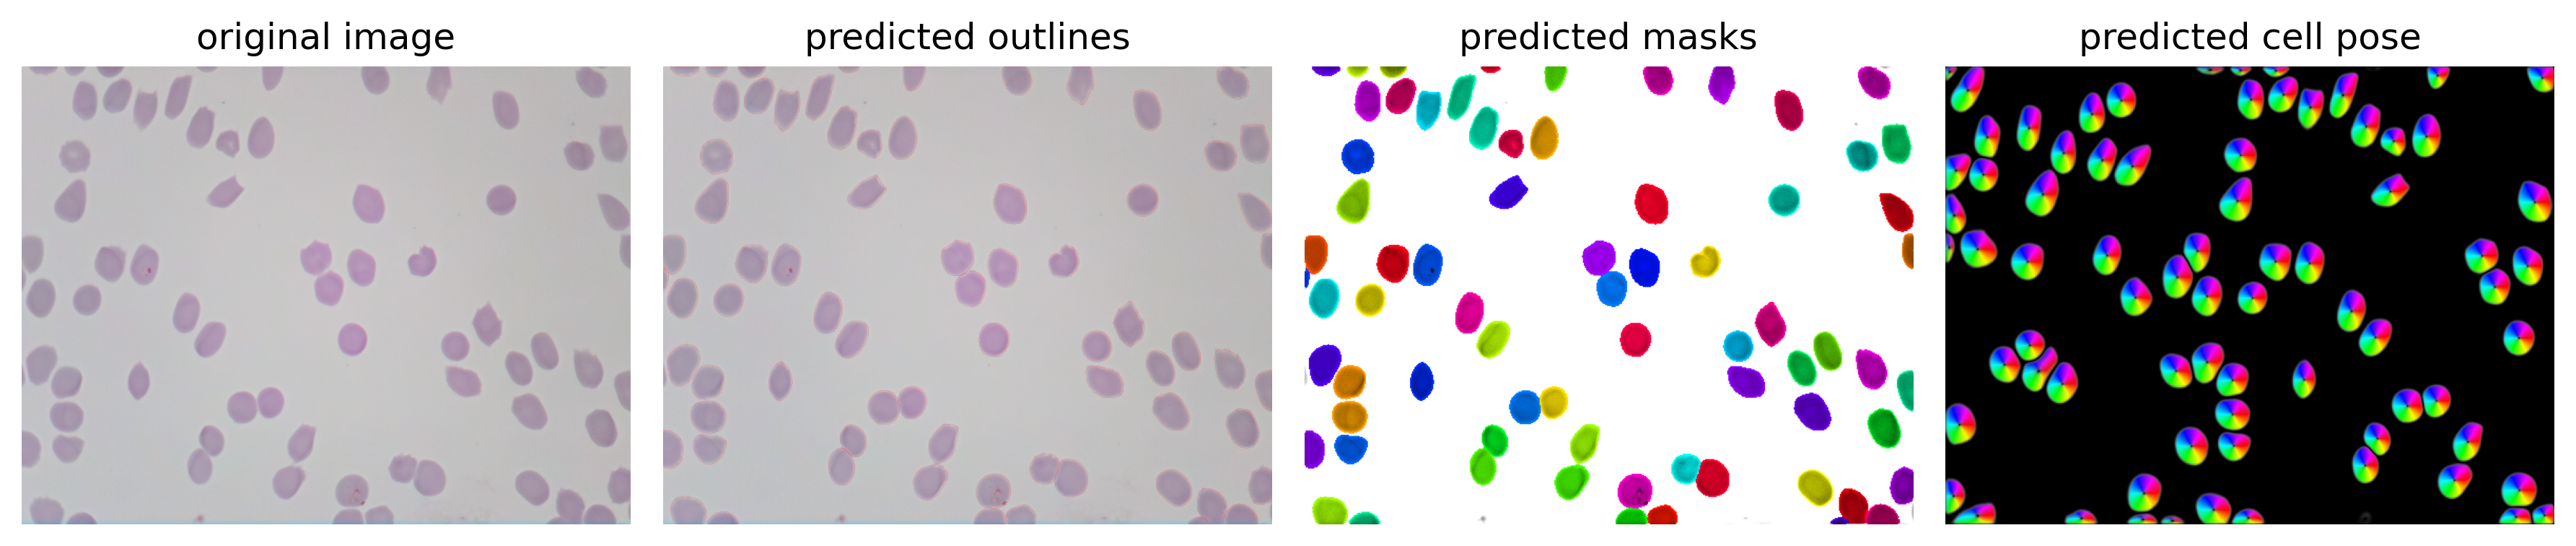

In [13]:
# quick test to check if for loop works and masks are correct

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, imgs[1], masks_all[1], flows[0], channels=chan)
plt.tight_layout()
plt.show()

In [14]:
outlines_0 = outlines_list(masks_all[0])

In [17]:

outlines_0[0]

array([[227,   0],
       [227,   1],
       [227,   2],
       [227,   3],
       [227,   4],
       [227,   5],
       [227,   6],
       [227,   7],
       [227,   8],
       [227,   9],
       [227,  10],
       [227,  11],
       [227,  12],
       [227,  13],
       [227,  14],
       [227,  15],
       [227,  16],
       [227,  17],
       [228,  17],
       [229,  17],
       [230,  17],
       [231,  17],
       [232,  17],
       [233,  18],
       [233,  19],
       [233,  20],
       [233,  21],
       [233,  22],
       [234,  22],
       [235,  22],
       [236,  22],
       [237,  22],
       [238,  22],
       [239,  23],
       [239,  24],
       [239,  25],
       [239,  26],
       [239,  27],
       [239,  28],
       [240,  28],
       [241,  28],
       [242,  28],
       [243,  28],
       [244,  28],
       [245,  29],
       [245,  30],
       [245,  31],
       [245,  32],
       [245,  33],
       [245,  34],
       [246,  34],
       [247,  34],
       [248,

In [16]:
# we basically need to do the opposite of what this function does

def outlines_to_x_y(outlines):
    arr_x = []
    arr_y = []
    for cell in outlines:
        arr_x.append(cell.flatten()[::2])
        arr_y.append(cell.flatten()[1::2])
    return arr_x, arr_y

list